<a href="https://colab.research.google.com/github/carbotton/tdl_tarea_1/blob/eda_preproc_data-aug/Tarea_1_letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

# Lo que hicimos...

Empezamos probando LeNet. Sabiamos que el resultado no iba a ser el mejor pero quisimos probar hasta donde podiamos llegar haciendole algunas modificaciones.

Luego de esto decidimos utilizar DenseNet.
Probamos correrla con su arquitectura original y los resultados fueron mucho mejores, notando grandes diferencias simplemente modificando batch_size e image_size

# Librerias y definiciones

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    evaluate,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
    plot_training,
    EarlyStopping,
    print_log,
    plot_training,
)

In [3]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
import sys
import os

# Configurar límite de memoria MPS para evitar errores de memoria
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando mps
Usando 0


In [5]:
BATCH_SIZE = 32  # tamaño del batch reducido para evitar problemas de memoria

# Exploracion de datos

## Carga de datos

In [6]:
DATA_DIR = Path("data")

# cargamos train y lo dividimos en train y val
imagenette_full_train = datasets.Imagenette(
    DATA_DIR, split="train", download=True
)

In [7]:
name_classes = imagenette_full_train.classes # no puedo usar imagenette_train_dataset.classes porque es un subset (surge de haber hecho el random split, no tengo mas atributos de clase ahi
NUM_CLASES = len(name_classes)

print(f"Clases: {name_classes}")

Clases: [('tench', 'Tinca tinca'), ('English springer', 'English springer spaniel'), ('cassette player',), ('chain saw', 'chainsaw'), ('church', 'church building'), ('French horn', 'horn'), ('garbage truck', 'dustcart'), ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'), ('golf ball',), ('parachute', 'chute')]


## Numero de clases y cantidad de imagenes por clase

In [8]:
root_dir = "data/imagenette2/train"
classes = os.listdir(root_dir)

class_counts = {}
for cls in classes:
    n_images = len(os.listdir(os.path.join(root_dir, cls)))
    class_counts[cls] = n_images

# Encontrar la clase con menos y más imágenes
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)

print(f"\nClase con MENOS imágenes: {min_class} ({class_counts[min_class]} imágenes)")
print(f"Clase con MÁS imágenes:  {max_class} ({class_counts[max_class]} imágenes)")
print(f"\nLa clase {max_class} tiene {((class_counts[max_class]-class_counts[min_class])/class_counts[max_class])*100:.1f}% más de imágenes que la clase {min_class}")



Clase con MENOS imágenes: n03000684 (858 imágenes)
Clase con MÁS imágenes:  n02979186 (993 imágenes)

La clase n02979186 tiene 13.6% más de imágenes que la clase n03000684


Todas tienen cantidades similares de imágenes.

Entre la clase que menos tiene y la que más, hay una diferencia de 135 imagenes.

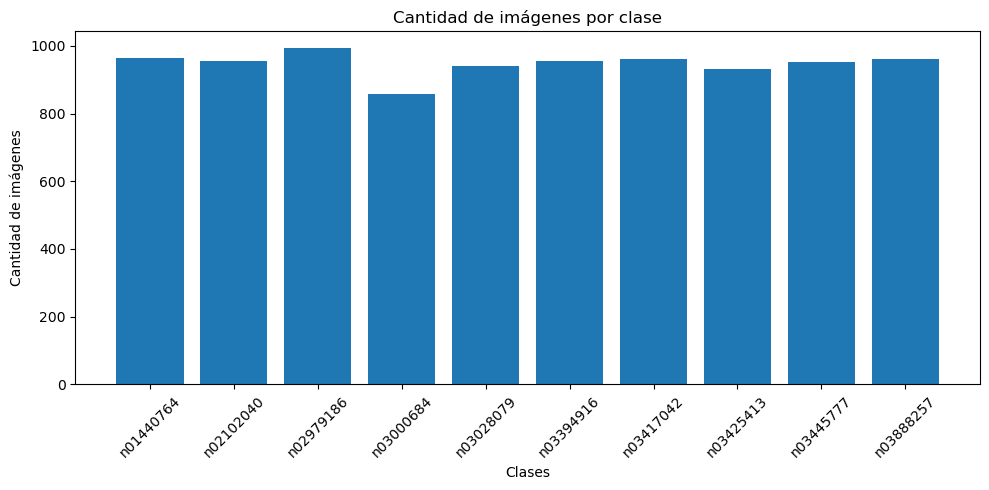

In [9]:
import matplotlib.pyplot as plt

# Ordenar clases para que el gráfico quede prolijo
sorted_classes = sorted(class_counts.keys())
sorted_counts = [class_counts[cls] for cls in sorted_classes]

plt.figure(figsize=(10, 5))
plt.bar(sorted_classes, sorted_counts)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Cantidad de imágenes")
plt.title("Cantidad de imágenes por clase")
plt.tight_layout()
plt.show()


## Ver selección random de imágenes

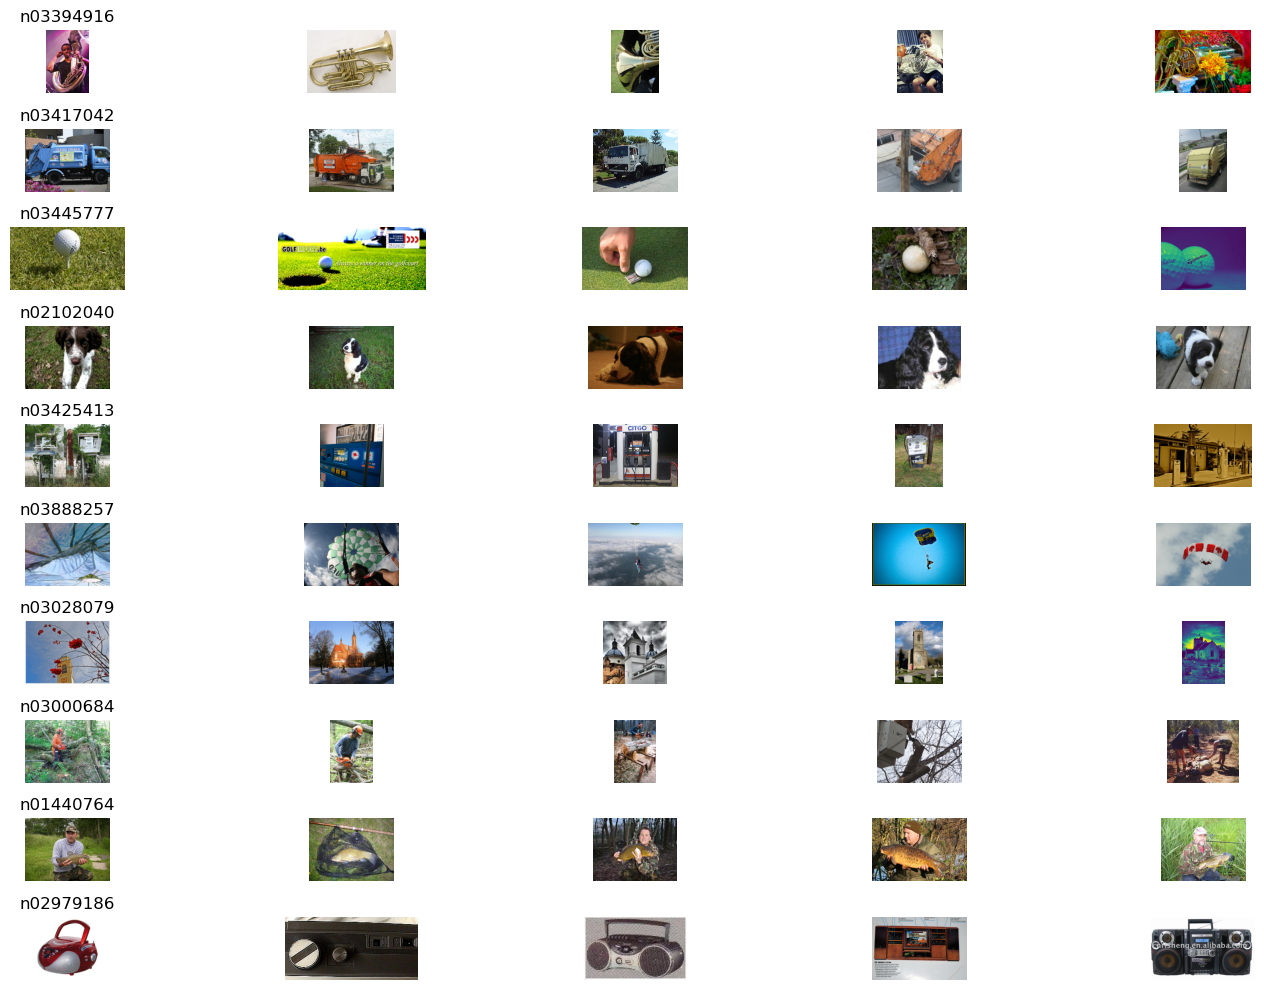

In [10]:
import random
import matplotlib.image as mpimg

n_samples = 5
fig, axs = plt.subplots(len(classes), n_samples, figsize=(15, 10))

for i, cls in enumerate(classes):
    img_files = os.listdir(os.path.join(root_dir, cls))
    for j in range(n_samples):
        img_path = os.path.join(root_dir, cls, random.choice(img_files))
        img = mpimg.imread(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        if j == 0:
            axs[i, j].set_title(cls)
plt.tight_layout()
plt.show()


## Ver tamaños de imágenes

Se puede observar que el tamaño de las imágenes difiere mucho entre una y otra.

In [11]:
from PIL import Image

sizes = []
for cls in classes:
    img_files = os.listdir(os.path.join(root_dir, cls))
    for img_file in img_files[:50]:  # muestra
        img_path = os.path.join(root_dir, cls, img_file)
        with Image.open(img_path) as img:
            sizes.append(img.size)  # (ancho, alto)

size_counts = {}
for size in sizes:
    if size not in size_counts:
        size_counts[size] = 0
    size_counts[size] += 1

# Encontrar el tamaño más y menos común
most_common_size = None
most_common_count = -1
least_common_size = None
least_common_count = float('inf')

for size, count in size_counts.items():
    if count > most_common_count:
        most_common_size = size
        most_common_count = count
    if count < least_common_count:
        least_common_size = size
        least_common_count = count

print(f"\nTotal de tamaños diferentes encontrados: {len(size_counts)}")
print(f"Tamaño MÁS común: {most_common_size} (aparece {most_common_count} veces)")
print(f"Tamaño MENOS común: {least_common_size} (aparece {least_common_count} veces)")



Total de tamaños diferentes encontrados: 215
Tamaño MÁS común: (500, 375) (aparece 124 veces)
Tamaño MENOS común: (1162, 773) (aparece 1 veces)


## Buscar duplicados

In [12]:
import hashlib

def md5(fname):
    with open(fname, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

hashes = {}
duplicates = []
for cls in classes:
    for img_file in os.listdir(os.path.join(root_dir, cls)):
        path = os.path.join(root_dir, cls, img_file)
        h = md5(path)
        if h in hashes:
            duplicates.append(path)
        else:
            hashes[h] = path
print(f"Encontradas {len(duplicates)} imágenes duplicadas.")


Encontradas 0 imágenes duplicadas.


## Conclusión de la exploracion de datos

Del análisis anterior podemos observar que las clases se encuentran balanceadas, ya que cada una posee un número similar de imágenes. Además, verificamos que no existen duplicados, por lo que no es necesario eliminar ninguna imagen. Finalmente, notamos que las imágenes presentan distintas dimensiones, por lo que es necesario aplicar un proceso de resize para garantizar la consistencia del conjunto de datos.

# LeNet

## Definiciones

In [13]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset CIFAR10 (si no lo tenemos ya)
    train_dataset = datasets.Imagenette(
        DATA_DIR, split="train", download=True, transform=None
    ) 
    test_dataset = datasets.Imagenette(
        DATA_DIR, split="val", download=False, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [14]:
IMG_SIZE = 128  # Reducir tamaño de imagen para ahorrar memoria

In [15]:
val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToDtype(torch.float32, scale=True),
])

In [16]:
train_dataset = datasets.Imagenette(
    DATA_DIR, split="train", download=False, transform=val_tfms_lenet
) 

# Stack todas las imágenes en un tensor
data = torch.stack([img for img, _ in train_dataset])
# Shape: (50000, 3, 32, 32)

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

Mean: tensor([0.4625, 0.4580, 0.4295])
Std: tensor([0.2768, 0.2730, 0.2967])


In [17]:
train_tfms_lenet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_lenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


## Regularization

### Data Augmentation
Aplicado en transformaciones sobre train

### Early stopping

Aplicado en training loop

### Dropout

Aplicado en training loop

## Arquitectura del modelo

In [18]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes, use_dropout=False, dropout_p=0.5):
        super(LeNet, self).__init__()
        self.use_dropout = use_dropout
        self.dropout_p = dropout_p

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=0)  # 140->136
        self.pool  = nn.AvgPool2d(kernel_size=2, stride=2)                                                   # /2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)           # 68->64
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0)         # 32->28
        # self.pool3 = nn.AvgPool2d(kernel_size=28, stride=28)  # 28x28 -> 1x1 (válido para entradas 140x140)
        self.pool3 = nn.AdaptiveAvgPool2d((1, 1))  # reemplaza al AvgPool2d(28,28)


        self.tanh = nn.Tanh()
        # self.linear = nn.Linear(120, 84)
        self.linear = nn.LazyLinear(84)   # en vez de nn.Linear(120, 84)

        self.output = nn.Linear(84, num_classes)
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(p=self.dropout_p) if self.use_dropout else nn.Identity()

    def forward(self, x):
        # x: [B, C=3, 140, 140]
        x = self.tanh(self.conv1(x))   # -> [B, 6, 136, 136]
        x = self.pool(x)               # -> [B, 6, 68, 68]
        x = self.tanh(self.conv2(x))   # -> [B, 16, 64, 64]
        x = self.pool(x)               # -> [B, 16, 32, 32]
        x = self.tanh(self.conv3(x))   # -> [B, 120, 28, 28]
        x = self.pool3(x)              # -> [B, 120, 1, 1]
        x = self.flatten(x)            # -> [B, 120]
        x = self.tanh(self.linear(x))  # -> [B, 84]
        x = self.dropout(x)
        x = self.output(x)             # -> [B, num_classes]
        return x


summary(LeNet(3, NUM_CLASES), input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 124, 124]         456
├─Tanh: 1-2                              [32, 6, 124, 124]         --
├─AvgPool2d: 1-3                         [32, 6, 62, 62]           --
├─Conv2d: 1-4                            [32, 16, 58, 58]          2,416
├─Tanh: 1-5                              [32, 16, 58, 58]          --
├─AvgPool2d: 1-6                         [32, 16, 29, 29]          --
├─Conv2d: 1-7                            [32, 120, 25, 25]         48,120
├─Tanh: 1-8                              [32, 120, 25, 25]         --
├─AdaptiveAvgPool2d: 1-9                 [32, 120, 1, 1]           --
├─Flatten: 1-10                          [32, 120]                 --
├─Linear: 1-11                           [32, 84]                  10,164
├─Tanh: 1-12                             [32, 84]                  --
├─I

## Entrenamiento con optimizaciones de memoria


In [19]:
LR = 0.001
EPOCHS = 100
criterion = nn.CrossEntropyLoss().to(DEVICE)
# optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

In [20]:


letnet_model = LeNet(3, NUM_CLASES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

# epoch_train_errors, epoch_val_errors = train(
#     letnet_model,
#     optimizer,
#     criterion,
#     train_loader,
#     val_loader,
#     DEVICE,
#     do_early_stopping=True,
#     patience=10,
#     epochs=EPOCHS,
#     log_fn=print_log,
#     log_every=1,
# )

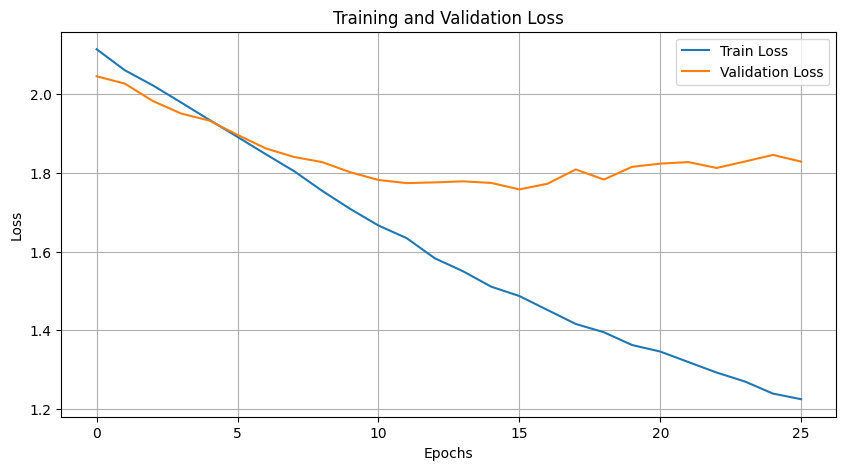

In [21]:
plot_training(epoch_train_errors, epoch_val_errors)

In [22]:
#model_classification_report(letnet_model, val_loader, DEVICE, NUM_CLASES)

Accuracy: 0.4102

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       193
           1       0.38      0.54      0.44       205
           2       0.50      0.45      0.48       204
           3       0.32      0.15      0.21       156
           4       0.38      0.40      0.39       188
           5       0.31      0.31      0.31       192
           6       0.43      0.44      0.44       198
           7       0.34      0.32      0.33       184
           8       0.36      0.40      0.38       186
           9       0.54      0.55      0.55       188

    accuracy                           0.41      1894
   macro avg       0.41      0.40      0.40      1894
weighted avg       0.41      0.41      0.41      1894



## Weight & Biases

In [23]:
import wandb

WANDB_TEAM_NAME = "mc-ort"
WANDB_PROJECT = "Tarea1_LeNet_3"
os.environ["WANDB_NOTEBOOK_NAME"] = "./Tarea_1_letra.ipynb"

wandb.login()

wandb: Currently logged in as: campiglianatalia (campiglianatalia-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [24]:
sweep_config = {
    "name": "tarea_1_lenet_memory_optimized",
    "method": "random",
    "metric": {"name": "val_macro_f1", "goal": "maximize"},  # o "val_accuracy"
    "parameters": {
        # Optimizador y LR
        "optimizer": {"values": ["adam", "sgd"]},
        "learning_rate": {"distribution": "log_uniform_values", "min": 1e-4, "max": 5e-3},
        "weight_decay": {"values": [0.0, 1e-4, 5e-4]},

        # Regularización en FC
        "dropout_p": {"values": [0.0, 0.2, 0.3]},

        # Data - Batch sizes más pequeños para evitar problemas de memoria
        "batch_size": {"values": [16, 32]},

        # Early stopping
        "early_stop": {"values": [True, False]},
        "patience": {"values": [4, 6]},   

        # Entrenamiento                
        "label_smoothing": {"values": [0.0, 0.05]},
        
        # Parámetros de optimización de memoria
        "gradient_accumulation_steps": {"values": [2, 4, 8]},
    },
}

sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

Create sweep with ID: zuiiqtvm
Sweep URL: https://wandb.ai/campiglianatalia-ort/Tarea1_LeNet_2/sweeps/zuiiqtvm


In [25]:
entity = wandb.api.default_entity
project = WANDB_PROJECT

print("Entity actual:", entity)
print("Project actual:", project)

Entity actual: campiglianatalia-ort
Project actual: Tarea1_LeNet_2


In [26]:
def wand_log(epoch, train_loss, val_loss):
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "val_loss": val_loss})


In [27]:
import time 

accuracies = []
precisions = []
recalls = []
f1_scores = []
supports = []

def sweep_run():
    """
    Función que se ejecutará en cada run del sweep.
    """
    # inicializar un nuevo run
    wandb.init()
    
    # leer la configuración del run
    config = wandb.config
    run_learning_rate = config.learning_rate
    run_optimizer = config.optimizer
    run_weight_decay = config.weight_decay
    run_dropout_p = config.dropout_p
    run_batch_size = config.batch_size
    run_early_stopping = config.early_stop
    run_patience = config.patience
    run_label_smoothing = config.label_smoothing


    # modelo
    if run_dropout_p == 0:
        model = LeNet(3, NUM_CLASES).to(DEVICE)
    else:
        model = LeNet(3, NUM_CLASES, True, run_dropout_p).to(DEVICE)

    # dataloaders  
    train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, run_batch_size, NUM_WORKERS)

    # optimizer
    if run_optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=run_learning_rate, weight_decay=run_weight_decay)
    elif run_optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=run_learning_rate, momentum=0.9, nesterov=True, weight_decay=run_weight_decay)

    # criterion
    if run_label_smoothing == 0:
        criterion = nn.CrossEntropyLoss().to(DEVICE)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=run_label_smoothing).to(DEVICE)

    def log_with_timing(epoch, train_loss, val_loss):
        if (epoch + 1) % 10 == 0:
            wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})
            print(f"[EPOCH {epoch+1}] train_loss={train_loss:.4f} val_loss={val_loss:.4f}", flush=True)        

    train(model, optimizer, criterion, train_loader, val_loader, device=DEVICE, do_early_stopping=run_early_stopping, patience=run_patience,
          epochs=EPOCHS, log_fn=log_with_timing, log_every=1)
    
    # guardo pesos temporalmente
    torch.save(model.state_dict(), "model.pth")
    wandb.save(f"model.pth")

    accuracy, precision, recall, f1score, support = model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1score)
    supports.append(support)


    wandb.finish()
    



In [28]:
wandb.agent(sweep_id, function=sweep_run, count=10) # corre sweep_run 10 veces

wandb: Agent Starting Run: qmiizrcs with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 8
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00022589256972824177
wandb: 	optimizer: adam
wandb: 	patience: 4
wandb: 	weight_decay: 0


[EPOCH 10] train_loss=1.8188 val_loss=1.8923
[EPOCH 20] train_loss=1.5774 val_loss=1.7984
Detener entrenamiento en la época 26, la mejor pérdida fue 1.77679


epoch,▁█
train_loss,█▁
val_loss,█▁
epoch,20
train_loss,1.57743
val_loss,1.7984


wandb: Agent Starting Run: wmpyu4oj with config:
wandb: 	batch_size: 64
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.002866956929347663
wandb: 	optimizer: adam
wandb: 	patience: 8
wandb: 	weight_decay: 0.0005


[RUN] starting train...
[EPOCH 10] train_loss=1.8298 val_loss=1.8518
[EPOCH 20] train_loss=1.6846 val_loss=1.7084
[EPOCH 30] train_loss=1.5808 val_loss=1.6127
[EPOCH 40] train_loss=1.5118 val_loss=1.5463
[EPOCH 50] train_loss=1.4446 val_loss=1.5060
Detener entrenamiento en la época 52, la mejor pérdida fue 1.48373


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.5042

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.51      0.71      0.59       387
           1       0.55      0.40      0.46       395
           2       0.47      0.66      0.55       357
           3       0.38      0.24      0.30       386
           4       0.57      0.50      0.53       409
           5       0.45      0.33      0.38       394
           6       0.55      0.56      0.55       389
           7       0.38      0.41      0.39       419
           8       0.46      0.60      0.52       399
           9       0.76      0.65      0.70       390

    accuracy                           0.50      3925
   macro avg       0.51      0.51      0.50      3925
weighted avg       0.51      0.50      0.50      3925



epoch,▁▃▅▆█
train_loss,█▅▃▂▁
val_loss,█▅▃▂▁
epoch,50
train_loss,1.44456
val_loss,1.50603


wandb: Agent Starting Run: 39sqckuv with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	gradient_accumulation_steps: 2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.003728064249190827
wandb: 	optimizer: adam
wandb: 	patience: 4
wandb: 	weight_decay: 0.0001


[RUN] starting train...
[EPOCH 10] train_loss=1.5829 val_loss=1.6587
[EPOCH 20] train_loss=1.3485 val_loss=1.4376
[EPOCH 30] train_loss=1.2150 val_loss=1.3338
[EPOCH 40] train_loss=1.1111 val_loss=1.2191
[EPOCH 50] train_loss=1.0440 val_loss=1.2289
[EPOCH 60] train_loss=1.0027 val_loss=1.2422
[EPOCH 70] train_loss=0.9432 val_loss=1.1699
[EPOCH 80] train_loss=0.9361 val_loss=1.2076
[EPOCH 90] train_loss=0.9039 val_loss=1.2148
[EPOCH 100] train_loss=0.8702 val_loss=1.1500


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.6349

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.76      0.69      0.72       387
           1       0.57      0.72      0.64       395
           2       0.55      0.73      0.63       357
           3       0.51      0.36      0.42       386
           4       0.64      0.60      0.62       409
           5       0.74      0.58      0.65       394
           6       0.56      0.75      0.64       389
           7       0.56      0.65      0.60       419
           8       0.78      0.58      0.66       399
           9       0.82      0.69      0.75       390

    accuracy                           0.63      3925
   macro avg       0.65      0.64      0.63      3925
weighted avg       0.65      0.63      0.63      3925



epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▄▃▃▂▂▂▁▁
val_loss,█▅▄▂▂▂▁▂▂▁
epoch,100
train_loss,0.87024
val_loss,1.15003


wandb: Agent Starting Run: b0j3adao with config:
wandb: 	batch_size: 16
wandb: 	dropout_p: 0.2
wandb: 	early_stop: False
wandb: 	gradient_accumulation_steps: 4
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.00010398571096015
wandb: 	optimizer: sgd
wandb: 	patience: 4
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] starting train...
[EPOCH 10] train_loss=2.1915 val_loss=2.1988
[EPOCH 20] train_loss=2.1575 val_loss=2.1713
[EPOCH 30] train_loss=2.1382 val_loss=2.1544
[EPOCH 40] train_loss=2.1229 val_loss=2.1390
[EPOCH 50] train_loss=2.0927 val_loss=2.1094
[EPOCH 60] train_loss=2.0530 val_loss=2.0706
[EPOCH 70] train_loss=2.0245 val_loss=2.0449
[EPOCH 80] train_loss=1.9939 val_loss=2.0172
[EPOCH 90] train_loss=1.9681 val_loss=1.9947
[EPOCH 100] train_loss=1.9461 val_loss=1.9788


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.3320

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.35      0.25      0.29       387
           1       0.25      0.15      0.19       395
           2       0.25      0.55      0.34       357
           3       0.23      0.10      0.14       386
           4       0.40      0.45      0.42       409
           5       0.27      0.48      0.34       394
           6       0.34      0.34      0.34       389
           7       0.24      0.07      0.10       419
           8       0.37      0.31      0.34       399
           9       0.58      0.65      0.61       390

    accuracy                           0.33      3925
   macro avg       0.33      0.34      0.31      3925
weighted avg       0.33      0.33      0.31      3925



epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_loss,█▇▇▆▅▄▃▂▂▁
epoch,100
train_loss,1.94606
val_loss,1.97877


wandb: Agent Starting Run: 6ci3s1hj with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 8
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00020569954683485065
wandb: 	optimizer: sgd
wandb: 	patience: 6
wandb: 	weight_decay: 0.0001


[RUN] starting train...
[EPOCH 10] train_loss=2.1778 val_loss=2.1854
[EPOCH 20] train_loss=2.1227 val_loss=2.1385
[EPOCH 30] train_loss=2.0689 val_loss=2.0842
[EPOCH 40] train_loss=2.0498 val_loss=2.0635
[EPOCH 50] train_loss=2.0331 val_loss=2.0499
[EPOCH 60] train_loss=2.0180 val_loss=2.0387
[EPOCH 70] train_loss=1.9950 val_loss=2.0185
[EPOCH 80] train_loss=1.9690 val_loss=1.9943
[EPOCH 90] train_loss=1.9355 val_loss=1.9669
[EPOCH 100] train_loss=1.9094 val_loss=1.9394


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.3358

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.33      0.36      0.35       387
           1       0.24      0.19      0.22       395
           2       0.26      0.52      0.35       357
           3       0.23      0.07      0.10       386
           4       0.42      0.34      0.38       409
           5       0.27      0.50      0.35       394
           6       0.35      0.37      0.36       389
           7       0.29      0.06      0.10       419
           8       0.36      0.29      0.32       399
           9       0.58      0.69      0.63       390

    accuracy                           0.34      3925
   macro avg       0.33      0.34      0.31      3925
weighted avg       0.33      0.34      0.31      3925



epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▅▅▄▄▃▃▂▁
val_loss,█▇▅▅▄▄▃▃▂▁
epoch,100
train_loss,1.90944
val_loss,1.93942


wandb: Agent Starting Run: 32n3lyf6 with config:
wandb: 	batch_size: 16
wandb: 	dropout_p: 0.3
wandb: 	early_stop: False
wandb: 	gradient_accumulation_steps: 8
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.00012067545042202114
wandb: 	optimizer: adam
wandb: 	patience: 6
wandb: 	weight_decay: 0


[RUN] starting train...
[EPOCH 10] train_loss=1.8727 val_loss=1.8873
[EPOCH 20] train_loss=1.7592 val_loss=1.7742
[EPOCH 30] train_loss=1.6516 val_loss=1.6683
[EPOCH 40] train_loss=1.5604 val_loss=1.5738
[EPOCH 50] train_loss=1.4768 val_loss=1.5116
[EPOCH 60] train_loss=1.4266 val_loss=1.5128
[EPOCH 70] train_loss=1.3806 val_loss=1.4264
[EPOCH 80] train_loss=1.3424 val_loss=1.3921
[EPOCH 90] train_loss=1.3007 val_loss=1.3575
[EPOCH 100] train_loss=1.2654 val_loss=1.3335


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.5521

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.71      0.65       387
           1       0.58      0.53      0.56       395
           2       0.48      0.68      0.56       357
           3       0.39      0.30      0.34       386
           4       0.66      0.51      0.58       409
           5       0.50      0.51      0.50       394
           6       0.49      0.71      0.58       389
           7       0.48      0.35      0.40       419
           8       0.60      0.58      0.59       399
           9       0.76      0.67      0.72       390

    accuracy                           0.55      3925
   macro avg       0.56      0.55      0.55      3925
weighted avg       0.56      0.55      0.55      3925



epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▅▄▃▃▂▂▁▁
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,100
train_loss,1.26543
val_loss,1.33347


wandb: Agent Starting Run: t6ypzdxq with config:
wandb: 	batch_size: 16
wandb: 	dropout_p: 0.2
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 8
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0007140186495002218
wandb: 	optimizer: adam
wandb: 	patience: 6
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] starting train...
[EPOCH 10] train_loss=1.6643 val_loss=1.6948
[EPOCH 20] train_loss=1.4729 val_loss=1.5193
[EPOCH 30] train_loss=1.3425 val_loss=1.3678
[EPOCH 40] train_loss=1.2502 val_loss=1.3187
Detener entrenamiento en la época 46, la mejor pérdida fue 1.27542


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.6201

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.80      0.60      0.69       387
           1       0.52      0.73      0.61       395
           2       0.64      0.64      0.64       357
           3       0.39      0.45      0.42       386
           4       0.59      0.73      0.66       409
           5       0.65      0.50      0.56       394
           6       0.64      0.75      0.69       389
           7       0.69      0.50      0.58       419
           8       0.63      0.63      0.63       399
           9       0.82      0.67      0.74       390

    accuracy                           0.62      3925
   macro avg       0.64      0.62      0.62      3925
weighted avg       0.64      0.62      0.62      3925



epoch,▁▃▆█
train_loss,█▅▃▁
val_loss,█▅▂▁
epoch,40
train_loss,1.25022
val_loss,1.31867


wandb: Agent Starting Run: xtxgzxtm with config:
wandb: 	batch_size: 16
wandb: 	dropout_p: 0.2
wandb: 	early_stop: False
wandb: 	gradient_accumulation_steps: 8
wandb: 	label_smoothing: 0.05
wandb: 	learning_rate: 0.0009034491022408848
wandb: 	optimizer: sgd
wandb: 	patience: 6
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] starting train...
[EPOCH 10] train_loss=2.0282 val_loss=2.0397
[EPOCH 20] train_loss=1.9128 val_loss=1.9284
[EPOCH 30] train_loss=1.8114 val_loss=1.8187
[EPOCH 40] train_loss=1.7043 val_loss=1.7224
[EPOCH 50] train_loss=1.6062 val_loss=1.6340
[EPOCH 60] train_loss=1.5355 val_loss=1.5445
[EPOCH 70] train_loss=1.4751 val_loss=1.4933
[EPOCH 80] train_loss=1.4285 val_loss=1.4638
[EPOCH 90] train_loss=1.3966 val_loss=1.4304
[EPOCH 100] train_loss=1.3564 val_loss=1.3894


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.5875

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.63      0.76      0.69       387
           1       0.56      0.70      0.62       395
           2       0.54      0.64      0.59       357
           3       0.48      0.24      0.32       386
           4       0.62      0.61      0.61       409
           5       0.51      0.64      0.57       394
           6       0.72      0.59      0.65       389
           7       0.62      0.32      0.42       419
           8       0.48      0.73      0.58       399
           9       0.85      0.66      0.74       390

    accuracy                           0.59      3925
   macro avg       0.60      0.59      0.58      3925
weighted avg       0.60      0.59      0.58      3925



epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▇▆▅▄▃▂▂▁▁
val_loss,█▇▆▅▄▃▂▂▁▁
epoch,100
train_loss,1.35641
val_loss,1.38936


wandb: Agent Starting Run: pi6lkutk with config:
wandb: 	batch_size: 16
wandb: 	dropout_p: 0
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0006502131084734124
wandb: 	optimizer: sgd
wandb: 	patience: 6
wandb: 	weight_decay: 0.0001


[RUN] init


[RUN] starting train...
[EPOCH 10] train_loss=2.0546 val_loss=2.0689
[EPOCH 20] train_loss=1.8726 val_loss=1.8978
[EPOCH 30] train_loss=1.7726 val_loss=1.7921
[EPOCH 40] train_loss=1.6619 val_loss=1.6879
[EPOCH 50] train_loss=1.5672 val_loss=1.6168
[EPOCH 60] train_loss=1.4778 val_loss=1.4993
[EPOCH 70] train_loss=1.4113 val_loss=1.4525
[EPOCH 80] train_loss=1.3436 val_loss=1.4016
[EPOCH 90] train_loss=1.3093 val_loss=1.4019
Detener entrenamiento en la época 92, la mejor pérdida fue 1.35962


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.5106

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.67      0.63       387
           1       0.48      0.58      0.52       395
           2       0.49      0.57      0.53       357
           3       0.40      0.11      0.17       386
           4       0.61      0.53      0.57       409
           5       0.49      0.52      0.51       394
           6       0.56      0.61      0.58       389
           7       0.41      0.23      0.29       419
           8       0.38      0.68      0.48       399
           9       0.72      0.63      0.67       390

    accuracy                           0.51      3925
   macro avg       0.51      0.51      0.50      3925
weighted avg       0.51      0.51      0.49      3925



epoch,▁▂▃▄▅▅▆▇█
train_loss,█▆▅▄▃▃▂▁▁
val_loss,█▆▅▄▃▂▂▁▁
epoch,90
train_loss,1.30932
val_loss,1.40187


wandb: Agent Starting Run: 212hrk4k with config:
wandb: 	batch_size: 32
wandb: 	dropout_p: 0.3
wandb: 	early_stop: True
wandb: 	gradient_accumulation_steps: 4
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0004051346484274032
wandb: 	optimizer: adam
wandb: 	patience: 6
wandb: 	weight_decay: 0.0005


[RUN] init


[RUN] starting train...
[EPOCH 10] train_loss=1.8114 val_loss=1.8081
[EPOCH 20] train_loss=1.6082 val_loss=1.6248
[EPOCH 30] train_loss=1.4734 val_loss=1.5014
[EPOCH 40] train_loss=1.3823 val_loss=1.4306
[EPOCH 50] train_loss=1.3104 val_loss=1.3835
[EPOCH 60] train_loss=1.2457 val_loss=1.2633
[EPOCH 70] train_loss=1.2075 val_loss=1.2735
Detener entrenamiento en la época 76, la mejor pérdida fue 1.21642


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.5768

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.72      0.67      0.69       387
           1       0.75      0.45      0.56       395
           2       0.39      0.81      0.53       357
           3       0.39      0.43      0.41       386
           4       0.69      0.45      0.55       409
           5       0.49      0.62      0.55       394
           6       0.69      0.55      0.61       389
           7       0.52      0.59      0.55       419
           8       0.73      0.55      0.63       399
           9       0.84      0.68      0.75       390

    accuracy                           0.58      3925
   macro avg       0.62      0.58      0.58      3925
weighted avg       0.62      0.58      0.58      3925



epoch,▁▂▃▅▆▇█
train_loss,█▆▄▃▂▁▁
val_loss,█▆▄▃▃▁▁
epoch,70
train_loss,1.20745
val_loss,1.27352


wandb: Agent Starting Run: r6bx20wj with config:
wandb: 	batch_size: 16
wandb: 	dropout_p: 0
wandb: 	early_stop: False
wandb: 	gradient_accumulation_steps: 2
wandb: 	label_smoothing: 0
wandb: 	learning_rate: 0.0018671033161077365
wandb: 	optimizer: sgd
wandb: 	patience: 6
wandb: 	weight_decay: 0


[RUN] init


[RUN] starting train...
[EPOCH 10] train_loss=1.8021 val_loss=1.8174
[EPOCH 20] train_loss=1.5731 val_loss=1.6386
[EPOCH 30] train_loss=1.3668 val_loss=1.4849
[EPOCH 40] train_loss=1.2560 val_loss=1.3115
[EPOCH 50] train_loss=1.1701 val_loss=1.2571
[EPOCH 60] train_loss=1.1025 val_loss=1.2181
[EPOCH 70] train_loss=1.0368 val_loss=1.1623
[EPOCH 80] train_loss=0.9797 val_loss=1.1373
[EPOCH 90] train_loss=0.9321 val_loss=1.1010
[EPOCH 100] train_loss=0.8918 val_loss=1.0969


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Accuracy: 0.6535

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.69      0.85      0.77       387
           1       0.74      0.69      0.71       395
           2       0.57      0.71      0.64       357
           3       0.53      0.27      0.36       386
           4       0.72      0.64      0.68       409
           5       0.57      0.72      0.63       394
           6       0.66      0.75      0.70       389
           7       0.59      0.57      0.58       419
           8       0.66      0.65      0.65       399
           9       0.80      0.71      0.75       390

    accuracy                           0.65      3925
   macro avg       0.65      0.65      0.65      3925
weighted avg       0.65      0.65      0.65      3925



epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▆▅▄▃▃▂▂▁▁
val_loss,█▆▅▃▃▂▂▁▁▁
epoch,100
train_loss,0.89184
val_loss,1.09689


## Evaluación final tomando mejor modelo

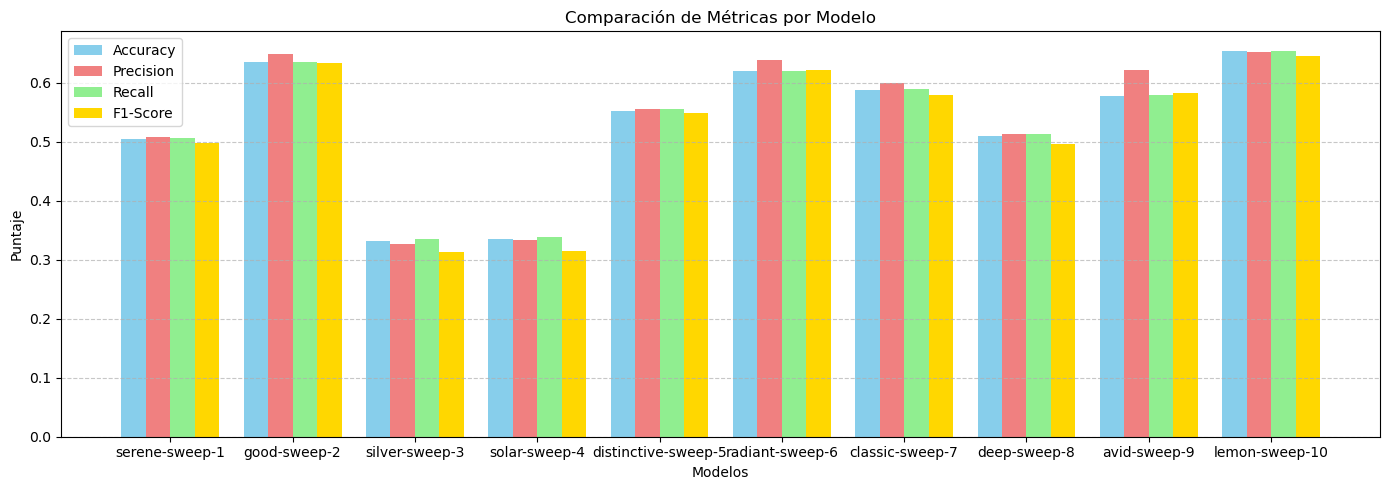


=== RESUMEN DE MÉTRICAS ===
Total de runs completados: 10

--- Accuracy ---
Mejor: lemon-sweep-10 0.6535

--- Precision ---
Mejor: lemon-sweep-10 0.6526

--- Recall ---
Mejor: lemon-sweep-10 0.6544

--- F1-Score ---
Mejor: lemon-sweep-10 0.6458


In [34]:
# Crear un bar chart que compare los resultados de los sweeps
import matplotlib.pyplot as plt
import numpy as np

# Obtener todos los runs del sweep
api = wandb.Api()
ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

# Extraer datos de todos los runs
runs = []
run_names = []

for run in sweep.runs:
    if run.state == "finished":  # Solo runs completados
        runs.append(run)
        run_names.append(run.name)

# Crear subplots para mostrar todas las métricas
# fig, axes = plt.subplots(2, 2, figsize=(20, 12))
# fig.suptitle('Métricas de Rendimiento por Sweep Run', fontsize=16, fontweight='bold')

# Configurar colores para cada métrica
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
metrics = [accuracies, precisions, recalls, f1_scores]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
y_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Crear gráfico combinado (manteniendo tu lógica)
x = np.arange(len(run_names))  # posiciones de las barras por modelo
width = 0.2  # ancho de cada barra

# Crear figura
fig, ax = plt.subplots(figsize=(14, 5))

# Dibujar cada métrica desplazada
for i, metric in enumerate(metrics):
    if len(metric) != len(run_names):
        print(f"⚠️ Longitud de {metric_names[i]} ({len(metric)}) no coincide con run_names ({len(run_names)}). Se omite.")
        continue
    ax.bar(x + i*width, metric, width, label=metric_names[i], color=colors[i])

# Personalización
ax.set_xlabel("Modelos")
ax.set_ylabel("Puntaje")
ax.set_title("Comparación de Métricas por Modelo")
ax.set_xticks(x + width * (len(metrics)-1)/2)
ax.set_xticklabels(run_names)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar
plt.tight_layout()
plt.show()

# Mostrar información adicional
print(f"\n=== RESUMEN DE MÉTRICAS ===")
print(f"Total de runs completados: {len(run_names)}")
print(f"\n--- Accuracy ---")
maxArg = np.argmax(accuracies)
print(f"Mejor: {run_names[maxArg]} {accuracies[maxArg]:.4f}")

print(f"\n--- Precision ---")
maxArg = np.argmax(precisions)
print(f"Mejor: {run_names[maxArg]} {precisions[maxArg]:.4f}")

print(f"\n--- Recall ---")
maxArg = np.argmax(recalls)
print(f"Mejor: {run_names[maxArg]} {recalls[maxArg]:.4f}")


print(f"\n--- F1-Score ---")
maxArg = np.argmax(f1_scores)
print(f"Mejor: {run_names[maxArg]} {f1_scores[maxArg]:.4f}")

# Mostrar tabla de resultados
# print(f"\n=== TABLA DE RESULTADOS ===")
# print(f"{'Run Name':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
# print("-" * 70)
# for i, name in enumerate(run_names):
#     print(f"{name:<20} {accuracies[i]:<10.4f} {precisions[i]:<10.4f} {recalls[i]:<10.4f} {f1_scores[i]:<10.4f}")




In [32]:
api = wandb.Api()

# ULTIMA CORRIDA
# Create sweep with ID: da8kuc8y
# Sweep URL: https://wandb.ai/mc-ort/Tarea1_LeNet_3/sweeps/da8kuc8y

ENTITY = api.default_entity
sweep = api.sweep(f"{ENTITY}/{WANDB_PROJECT}/{sweep_id}")

# nos traemos el sweep (objeto) para analizar los resultados
# sweep = api.sweep(f"{WANDB_TEAM_NAME}/{WANDB_PROJECT}/{sweep_id}")
 
# obtenemos el mejor run
best_run = sweep.best_run()

# imprimimos el mejor run
print("best run:", best_run)
# print(f"Best run {best_run.name} with {best_run.summary['val_loss']} {best_run.id}")
# print("Best run metrics:", best_run.summary)

print("Best run name:", best_run.name)
print("Best run name:", best_run.id)
print("Best run config:", best_run.config)

# descargamos el modelo del mejor run
best_run.file("model.pth").download(replace=True)

wandb: Sorting runs by -summary_metrics.val_macro_f1


best run: <Run campiglianatalia-ort/Tarea1_LeNet_2/212hrk4k (finished)>
Best run name: avid-sweep-9
Best run name: 212hrk4k
Best run config: {"_wandb": {"value": {"e": {"c1hik7zycrgbvj1kaal5q7jqnosbhazk": {"os": "macOS-15.1-arm64-arm-64bit-Mach-O", "git": {"commit": "c415e1769df9b8fa9c6677103193c0e01ecda3b9", "remote": "https://github.com/nataliacampiglia/tdl_tarea_1.git"}, "disk": {"/": {"used": "220938919936", "total": "494384795648"}}, "host": "192.168.1.55", "root": "/Users/nataliacampigliastemphelet/master/tdl_tarea_1", "apple": {"name": "Apple M4 Pro", "gpuCores": 16, "memoryGb": 24, "ecpuCores": 4, "pcpuCores": 8, "ramTotalBytes": "25769803776", "swapTotalBytes": "9663676416"}, "email": "campiglianatalia@gmail.com", "memory": {"total": "25769803776"}, "python": "CPython 3.13.7", "program": "./Tarea_1_letra.ipynb", "codePath": "Tarea_1_letra.ipynb", "writerId": "c1hik7zycrgbvj1kaal5q7jqnosbhazk", "cpu_count": 12, "startedAt": "2025-10-13T11:02:35.570745Z", "executable": "/Users/n

<_io.TextIOWrapper name='./model.pth' mode='r' encoding='UTF-8'>

In [ ]:
attrs = [a for a in dir(best_run) if not a.startswith("_")]
print(attrs)

['client', 'config', 'create', 'delete', 'dir', 'display', 'entity', 'file', 'files', 'history', 'id', 'json_config', 'lastHistoryStep', 'load', 'load_full_data', 'log_artifact', 'logged_artifacts', 'metadata', 'name', 'path', 'project', 'rawconfig', 'save', 'scan_history', 'server_provides_internal_id_field', 'snake_to_camel', 'state', 'storage_id', 'summary', 'summary_metrics', 'sweep', 'sweep_name', 'system_metrics', 'to_html', 'update', 'upload_file', 'url', 'use_artifact', 'used_artifacts', 'user', 'username', 'wait_until_finished']


In [ ]:
print("SUMMARY:",best_run.summary_metrics)


SUMMARY: {"_runtime":103,"_step":1,"_timestamp":1760299466.126972,"_wandb":{"runtime":103},"epoch":2,"train_loss":2.186723080616963,"val_loss":2.189457426552011}


In [ ]:
import json

s = best_run.summary_metrics  # o best_run.summary
if isinstance(s, dict):
    val_loss = s.get("val_loss")
elif isinstance(s, str):
    val_loss = json.loads(s).get("val_loss")
else:
    # fallback por si W&B lo envuelve en un objeto raro
    val_loss = getattr(s, "get", lambda *_: None)("val_loss")

print("val_loss:", val_loss)

val_loss: 2.189457426552011


In [ ]:
# restauramos el modelo
letnet_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:

criterion = nn.CrossEntropyLoss().to(DEVICE)

# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 2.17255


In [ ]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.1827

Reporte de clasificación:
               precision    recall  f1-score      support
0              0.091168  0.082687  0.086721   387.000000
1              0.000000  0.000000  0.000000   395.000000
2              0.132632  0.176471  0.151442   357.000000
3              0.750000  0.007772  0.015385   386.000000
4              0.000000  0.000000  0.000000   409.000000
5              0.154196  0.774112  0.257167   394.000000
6              0.295918  0.074550  0.119097   389.000000
7              0.200000  0.002387  0.004717   419.000000
8              0.000000  0.000000  0.000000   399.000000
9              0.280079  0.728205  0.404558   390.000000
accuracy       0.182675  0.182675  0.182675     0.182675
macro avg      0.190399  0.184618  0.103909  3925.000000
weighted avg   0.188797  0.182675  0.102158  3925.000000
Macro Avg:
 {'precision': 0.19039930906609953, 'recall': 0.18461835141735797, 'f1-score': 0.10390866329397616, 'support': 3925.0}
Precision:
 0.1903993090660

/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/nataliacampigliastemphelet/miniconda3/envs/taller-dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

(0.1826751592356688,
 0.19039930906609953,
 0.18461835141735797,
 0.10390866329397616,
 3925.0)

In [ ]:
import wandb, json

api = wandb.Api()

ENTITY = api.default_entity  # usá el entity correcto según tu URL
RUN_ID  = "4n4q5wiq"               # <- el run que querés

# 1) Traer el run por path
run_path = f"{ENTITY}/{WANDB_PROJECT}/{RUN_ID}"
run = api.run(run_path)

print("RUN:", run.id, "| name:", run.name)
print("URL:", run.url)
print("STATE:", run.state)
print("CONFIG:", dict(run.config))

# 2) Leer summary de forma segura (algunas versiones lo devuelven como string)
def summary_dict(r):
    s = getattr(r, "summary_metrics", None)
    if isinstance(s, str):
        try:
            return json.loads(s)
        except Exception:
            return {}
    if isinstance(s, dict):
        return s
    # fallback para r.summary con wrapper antiguo
    s2 = getattr(getattr(r, "summary", {}), "_json_dict", {})
    if isinstance(s2, dict):
        return s2
    return {}

summary = summary_dict(run)
print("SUMMARY KEYS:", [k for k in summary.keys() if not k.startswith("_")])
print("val_loss:", summary.get("val_loss"))

# 3) Descargar el modelo de ese run
#    Si el archivo exacto no existe, listá los .pth disponibles.
try:
    run.file("model.pth").download(replace=True)
    print("Descargado: model.pth")
except Exception as e:
    print("No encontré model.pth directamente:", e)
    print("Buscando .pth disponibles en el run...")
    pth_files = [f for f in run.files() if f.name.endswith(".pth")]
    for f in pth_files:
        print("->", f.name, f.size)
    if pth_files:
        pth_files[0].download(replace=True)
        print("Descargado:", pth_files[0].name)
    else:
        print("No hay archivos .pth en este run.")


RUN: 4n4q5wiq | name: clean-sweep-13
URL: https://wandb.ai/campiglianatalia-ort/Tarea1_LeNet_2/runs/4n4q5wiq
STATE: finished
CONFIG: {'patience': 6, 'dropout_p': 0.2, 'optimizer': 'adam', 'batch_size': 16, 'early_stop': True, 'weight_decay': 0.0001, 'learning_rate': 0.0012923728796005376, 'label_smoothing': 0.05, 'gradient_accumulation_steps': 8}
SUMMARY KEYS: ['epoch', 'train_loss', 'val_loss']
val_loss: 1.8528899470965068
Descargado: model.pth


In [ ]:
letnet_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [ ]:
def getValue(data, value_name):
    if isinstance(data, dict):
        value = data.get(value_name)
    elif isinstance(data, str):
        value = json.loads(data).get(value_name)
    else:
        # fallback por si W&B lo envuelve en un objeto raro
        value = getattr(data, "get", lambda *_: None)(value_name)

    print("val_loss:", val_loss)
    return value

In [ ]:

criterion = nn.CrossEntropyLoss().to(DEVICE)

# este get_dataloaders no deberia estar aca, lo puse de mientras porque me estaba dando un error que no reconocia variables, puede ser porque estuvo wandb corriendo tantas horas que perdio contexto???
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)
   
    
# Evaluamos el modelo en el conjunto de test
test_loss = evaluate(letnet_model, criterion, test_loader, DEVICE)  # tengo que traer el criterion que se halla usado en ese modelo

print(f"Test Loss: {test_loss:.5f}")

Test Loss: 1.79953


In [33]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.3885

Reporte de clasificación:
               precision    recall  f1-score      support
0              0.469274  0.434109  0.451007   387.000000
1              0.386525  0.275949  0.322009   395.000000
2              0.281134  0.638655  0.390411   357.000000
3              0.231214  0.103627  0.143113   386.000000
4              0.513433  0.420538  0.462366   409.000000
5              0.288646  0.535533  0.375111   394.000000
6              0.404199  0.395887  0.400000   389.000000
7              0.291892  0.128878  0.178808   419.000000
8              0.538776  0.330827  0.409938   399.000000
9              0.606132  0.658974  0.631450   390.000000
accuracy       0.388535  0.388535  0.388535     0.388535
macro avg      0.401122  0.392298  0.376421  3925.000000
weighted avg   0.402171  0.388535  0.375440  3925.000000
Macro Avg:
 {'precision': 0.4011224319805695, 'recall': 0.39229777893714146, 'f1-score': 0.3764211403372206, 'support': 3925.0}
Precision:
 0.401122431980569

(0.3885350318471338,
 0.4011224319805695,
 0.39229777893714146,
 0.3764211403372206,
 3925.0)

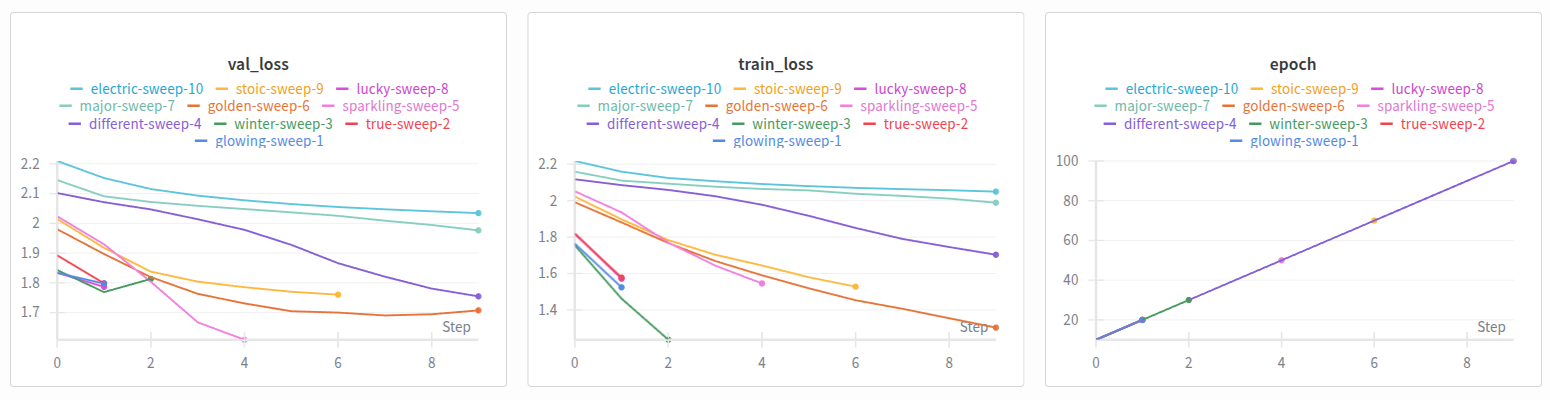

## Conclusión de los datos

# Arquitectura DenseNet


In [ ]:
IMG_SIZE = 128

In [ ]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

`growth_rate` indica cuántos canales se agregarán en cada capa convolucional dentro de un bloque denso

In [ ]:
from torchinfo import summary

in_channels  = 6  # número de canales de entrada
out_channels = 4 # número de canales de salida
dense_layer = DenseLayer(in_channels=in_channels, out_channels=out_channels)
summary(dense_layer, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
DenseLayer                               [32, 10, 128, 128]        --
├─BatchNorm2d: 1-1                       [32, 6, 128, 128]         12
├─ReLU: 1-2                              [32, 6, 128, 128]         --
├─Conv2d: 1-3                            [32, 4, 128, 128]         220
Total params: 232
Trainable params: 232
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.34
Input size (MB): 12.58
Forward/backward pass size (MB): 41.94
Params size (MB): 0.00
Estimated Total Size (MB): 54.53

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [ ]:
in_channels = 6  # número de canales de entrada
num_layer   = 5  # número de capas en el bloque denso
growth_rate = 4  # tasa de crecimiento

dense_block = DenseBlock(num_layer, in_channels, growth_rate)

summary(dense_block, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
DenseBlock                               [32, 26, 128, 128]        --
├─Sequential: 1-1                        [32, 26, 128, 128]        --
│    └─DenseLayer: 2-1                   [32, 10, 128, 128]        --
│    │    └─BatchNorm2d: 3-1             [32, 6, 128, 128]         12
│    │    └─ReLU: 3-2                    [32, 6, 128, 128]         --
│    │    └─Conv2d: 3-3                  [32, 4, 128, 128]         220
│    └─DenseLayer: 2-2                   [32, 14, 128, 128]        --
│    │    └─BatchNorm2d: 3-4             [32, 10, 128, 128]        20
│    │    └─ReLU: 3-5                    [32, 10, 128, 128]        --
│    │    └─Conv2d: 3-6                  [32, 4, 128, 128]         364
│    └─DenseLayer: 2-3                   [32, 18, 128, 128]        --
│    │    └─BatchNorm2d: 3-7             [32, 14, 128, 128]        28
│    │    └─ReLU: 3-8                    [32, 14, 128, 128]        --
│    │    └─C

In [ ]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = self.conv(self.bn(x))
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

In [ ]:
in_channels = 100  # número de canales de entrada
out_channels = 25  # número de canales de salida (en general, se reduce a la mitad)
img_w = 32  # ancho de la imagen
img_h = 32  # alto de la imagen

transition_layer = TransitionLayer(in_channels, out_channels)

summary(transition_layer, input_size=(BATCH_SIZE, in_channels, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
TransitionLayer                          [32, 25, 64, 64]          --
├─BatchNorm2d: 1-1                       [32, 100, 128, 128]       200
├─ReLU: 1-2                              [32, 100, 128, 128]       --
├─Conv2d: 1-3                            [32, 25, 128, 128]        2,525
├─AvgPool2d: 1-4                         [32, 25, 64, 64]          --
Total params: 2,725
Trainable params: 2,725
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.32
Input size (MB): 209.72
Forward/backward pass size (MB): 524.29
Params size (MB): 0.01
Estimated Total Size (MB): 734.01

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                            [32, 64, 128, 128]        128
├─ReLU: 1-3                                   [32, 64, 128, 128]        --
├─Sequential: 1-4                             [32, 1024, 16, 16]        --
│    └─DenseBlock: 2-1                        [32, 256, 128, 128]       --
│    │    └─Sequential: 3-1                   [32, 256, 128, 128]       250,752
│    └─TransitionLayer: 2-2                   [32, 128, 64, 64]         --
│    │    └─BatchNorm2d: 3-2                  [32, 256, 128, 128]       512
│    │    └─ReLU: 3-3                         [32, 256, 128, 128]       --
│    │    └─Conv2d: 3-4                       [32, 128, 128, 128]       32,896
│    │    └─AvgPool2d: 3-5                    [32, 128, 64, 64]         --
│    └

In [ ]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_lenet, val_tfms_lenet, BATCH_SIZE, NUM_WORKERS)


In [ ]:
import torch, gc

def mps_cleanup():
    gc.collect()
    if torch.backends.mps.is_available():
        print('clean')
        torch.mps.empty_cache()
        torch.mps.synchronize()

# Llama esto entre épocas o antes de relanzar un experimento
mps_cleanup()

clean


In [ ]:
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.95"
import torch

In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 2.02012 | Val Loss: 2.10934


KeyboardInterrupt: 

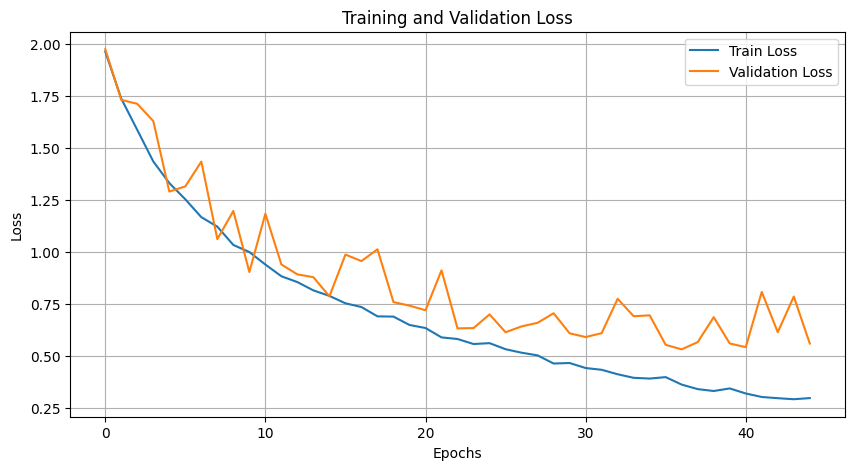

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8375

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.90      0.89      0.89       387
           1       0.97      0.82      0.89       395
           2       0.77      0.90      0.83       357
           3       0.63      0.75      0.68       386
           4       0.91      0.85      0.88       409
           5       0.82      0.86      0.84       394
           6       0.84      0.90      0.87       389
           7       0.83      0.75      0.79       419
           8       0.85      0.86      0.86       399
           9       0.94      0.80      0.87       390

    accuracy                           0.84      3925
   macro avg       0.85      0.84      0.84      3925
weighted avg       0.85      0.84      0.84      3925



In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
train_tfms_denseNet = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    # Transformaciones comunes:
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_denseNet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.Normalize(mean=T_MEAN, std=T_STD),
])

In [ ]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_denseNet, val_tfms_denseNet, BATCH_SIZE, NUM_WORKERS)

In [ ]:
import torch, gc


gc.collect()                 # Limpia objetos Python no referenciados
torch.cuda.empty_cache()     # Devuelve memoria al driver (visible en nvidia-smi)
torch.cuda.ipc_collect()


In [ ]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=NUM_CLASES
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 148.00 MiB. GPU 0 has a total capacity of 10.57 GiB of which 35.12 MiB is free. Process 2809942 has 10.53 GiB memory in use. Of the allocated memory 9.85 GiB is allocated by PyTorch, and 496.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
print(torch.cuda.memory_summary(abbreviated=True))
# durante entrenamiento
print("alloc:", torch.cuda.memory_allocated()/1024**2, "MB",
      "reserved:", torch.cuda.memory_reserved()/1024**2, "MB")

## Definiciones

In [35]:
IMG_SIZE = 128 # image size lo mas grande posible para tener mas resolucion

## Arquitectura

In [36]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y] , dim=1)

In [37]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        self.denseBlock = nn.Sequential(*self.block)
        

    def forward(self, x):
       return self.denseBlock(x)

In [38]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True) #optional
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = self.conv(self.bn(x))
        x = self.conv(self.relu(self.bn(x))) #relu es opcional
        return self.pool(x)

In [39]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10, dropout_p=0.0):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3
        self.convI = nn.Conv2d(current_channels, 2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        self.poolI = nn.MaxPool2d(2, 2)
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)

        dense_blocks = []
        # Bloques densos y capas de transición en nn.Sequential
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks - 1:
                dense_blocks += [TransitionLayer(current_channels, current_channels // 2)]
                current_channels = current_channels // 2
        self.dense_blocks = nn.Sequential(*dense_blocks)

        # Capa de clasificación
        self.avgPool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)
        

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [32, 10]                  --
├─Conv2d: 1-1                                 [32, 64, 128, 128]        1,792
├─BatchNorm2d: 1-2                            [32, 64, 128, 128]        128
├─ReLU: 1-3                                   [32, 64, 128, 128]        --
├─Sequential: 1-4                             [32, 1024, 16, 16]        --
│    └─DenseBlock: 2-1                        [32, 256, 128, 128]       --
│    │    └─Sequential: 3-1                   [32, 256, 128, 128]       250,752
│    └─TransitionLayer: 2-2                   [32, 128, 64, 64]         --
│    │    └─BatchNorm2d: 3-2                  [32, 256, 128, 128]       512
│    │    └─ReLU: 3-3                         [32, 256, 128, 128]       --
│    │    └─Conv2d: 3-4                       [32, 128, 128, 128]       32,896
│    │    └─AvgPool2d: 3-5                    [32, 128, 64, 64]         --
│    └

## Carga de datos con transforms

In [44]:
train_tfms_densenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),

    # Geométricas
    T.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),

    # Fotométricas que resaltan textura
    T.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5),
    T.RandomEqualize(p=0.3),              # si no usas CLAHE
    T.RandomAutocontrast(p=0.3),

    # Invariancia a blur para no sobreajustar a bordes perfectos
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),

    T.Normalize(mean=T_MEAN, std=T_STD),
])

val_tfms_densenet = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.Normalize(mean=T_MEAN, std=T_STD),
])


In [45]:
train_loader, val_loader, test_loader = get_dataloaders(train_tfms_densenet, val_tfms_densenet, BATCH_SIZE, NUM_WORKERS)

## Entrenamiento DenseNet Original

In [46]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

CRITERION = nn.CrossEntropyLoss().to(DEVICE)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 2.11489 | Val Loss: 1.97904
Epoch: 002 | Train Loss: 1.86558 | Val Loss: 1.75006
Epoch: 003 | Train Loss: 1.72256 | Val Loss: 2.25827
Epoch: 004 | Train Loss: 1.62363 | Val Loss: 1.89853
Epoch: 005 | Train Loss: 1.51061 | Val Loss: 1.46079
Epoch: 006 | Train Loss: 1.44385 | Val Loss: 1.44889
Epoch: 007 | Train Loss: 1.35436 | Val Loss: 1.20573
Epoch: 008 | Train Loss: 1.29015 | Val Loss: 1.59382
Epoch: 009 | Train Loss: 1.22554 | Val Loss: 1.14694
Epoch: 010 | Train Loss: 1.13176 | Val Loss: 1.02947
Epoch: 011 | Train Loss: 1.10715 | Val Loss: 1.01747
Epoch: 012 | Train Loss: 1.07388 | Val Loss: 1.16928
Epoch: 013 | Train Loss: 1.00028 | Val Loss: 0.90013
Epoch: 014 | Train Loss: 1.00860 | Val Loss: 1.34850
Epoch: 015 | Train Loss: 0.95402 | Val Loss: 0.77419
Epoch: 016 | Train Loss: 0.91522 | Val Loss: 0.76202
Epoch: 017 | Train Loss: 0.86850 | Val Loss: 0.88324
Epoch: 018 | Train Loss: 0.85913 | Val Loss: 0.82798
Epoch: 019 | Train Loss: 0.83601 | Val Loss: 0

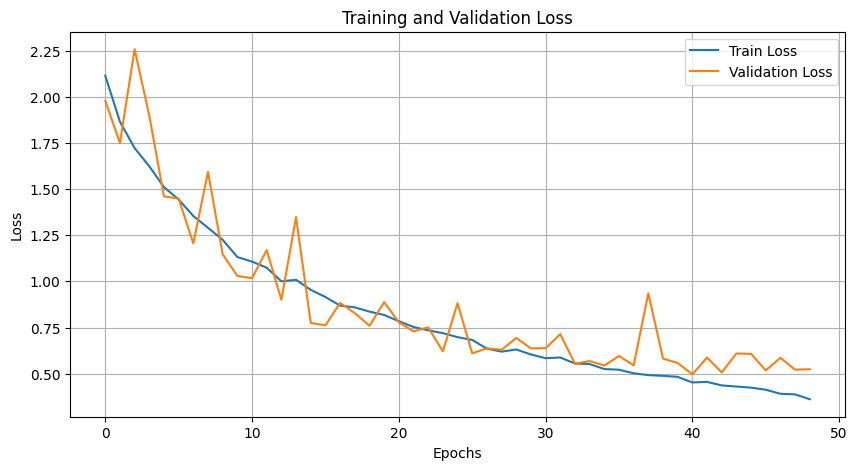

In [49]:
plot_training(train_errors_dn, val_errors_dn)

In [50]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8270

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89       387
           1       0.98      0.80      0.88       395
           2       0.68      0.93      0.79       357
           3       0.67      0.68      0.67       386
           4       0.79      0.92      0.85       409
           5       0.85      0.76      0.80       394
           6       0.94      0.79      0.85       389
           7       0.78      0.78      0.78       419
           8       0.88      0.88      0.88       399
           9       0.87      0.86      0.87       390

    accuracy                           0.83      3925
   macro avg       0.84      0.83      0.83      3925
weighted avg       0.84      0.83      0.83      3925



## Entrenamiento DenseNet con cosine decay

In [51]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_cosine_decay(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    do_early_stopping=True,
    patience=5,
    epochs=10,
    log_fn=print_log,
    log_every=1,
    eta_min=1e-6,
):
    """
    Entrena el modelo utilizando Cosine Decay (CosineAnnealingLR) para el learning rate.
    """

    epoch_train_errors = []
    epoch_val_errors = []

    if do_early_stopping:
        early_stopping = EarlyStopping(patience=patience)

    # Scheduler Cosine Decay
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            
            output = model(x)
            batch_loss = criterion(output, y)
            
            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item()

        train_loss /= len(train_loader)
        epoch_train_errors.append(train_loss)

        val_loss = evaluate(model, criterion, val_loader, device)
        epoch_val_errors.append(val_loss)

        # Step del scheduler (una vez por epoch)
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]

        if do_early_stopping:
            early_stopping(val_loss)

        if log_fn is not None and (epoch + 1) % log_every == 0:
            log_fn(epoch, train_loss, val_loss)
            print(f"[EPOCH {epoch+1}] lr={current_lr:.6e} train_loss={train_loss:.4f} val_loss={val_loss:.4f}")

        if do_early_stopping and early_stopping.early_stop:
            print(f"⏹ Detener entrenamiento en la época {epoch+1}, mejor val_loss={early_stopping.best_score:.5f}")
            break

    return epoch_train_errors, epoch_val_errors


In [52]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

train_errors_dn, val_errors_dn = train_cosine_decay(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=8,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 2.12610 | Val Loss: 1.91921
[EPOCH 1] lr=9.997535e-04 train_loss=2.1261 val_loss=1.9192
Epoch: 002 | Train Loss: 1.87615 | Val Loss: 1.82717
[EPOCH 2] lr=9.990144e-04 train_loss=1.8761 val_loss=1.8272
Epoch: 003 | Train Loss: 1.74153 | Val Loss: 1.96187
[EPOCH 3] lr=9.977832e-04 train_loss=1.7415 val_loss=1.9619
Epoch: 004 | Train Loss: 1.58320 | Val Loss: 1.54381
[EPOCH 4] lr=9.960613e-04 train_loss=1.5832 val_loss=1.5438
Epoch: 005 | Train Loss: 1.49228 | Val Loss: 1.70459
[EPOCH 5] lr=9.938503e-04 train_loss=1.4923 val_loss=1.7046
Epoch: 006 | Train Loss: 1.43044 | Val Loss: 1.52724
[EPOCH 6] lr=9.911525e-04 train_loss=1.4304 val_loss=1.5272
Epoch: 007 | Train Loss: 1.33063 | Val Loss: 1.28605
[EPOCH 7] lr=9.879704e-04 train_loss=1.3306 val_loss=1.2860
Epoch: 008 | Train Loss: 1.28326 | Val Loss: 1.40910
[EPOCH 8] lr=9.843073e-04 train_loss=1.2833 val_loss=1.4091
Epoch: 009 | Train Loss: 1.20978 | Val Loss: 1.10766
[EPOCH 9] lr=9.801667e-04 train_loss=1.2098

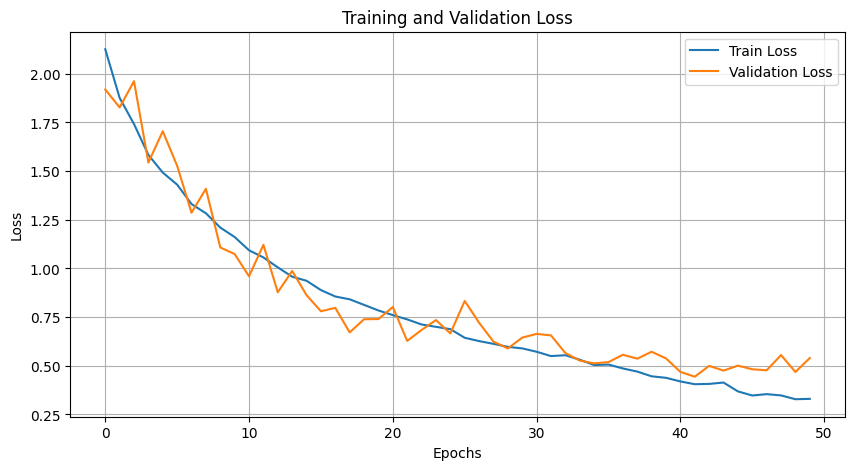

In [53]:
plot_training(train_errors_dn, val_errors_dn)

In [54]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8415

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90       387
           1       0.90      0.91      0.91       395
           2       0.82      0.86      0.84       357
           3       0.70      0.72      0.71       386
           4       0.85      0.89      0.87       409
           5       0.89      0.71      0.79       394
           6       0.89      0.81      0.85       389
           7       0.71      0.86      0.78       419
           8       0.86      0.88      0.87       399
           9       0.90      0.89      0.90       390

    accuracy                           0.84      3925
   macro avg       0.85      0.84      0.84      3925
weighted avg       0.85      0.84      0.84      3925



## Weight & Biases

## Conclusión de los datos

# Comparación de todos los modelos

Usando best-model wandb de cada uno

* Tabla comparativa de métricas (accuracy, F1, etc.).
* Gráficas comparativas.
* Matrices de confusión lado a lado.
* Discusión de resultados.